# Logistic Regression 
- sigmoid function 可以幫助任何值縮放到0-1之間
- 將 linear regression 的式子放入 Sigmoid function 1/1+e^-(z) ，代入z
- 因為 logistic regression 是 classification的方法，所以要將sigmoid function 找出分界點，可以分出 1 或 0，因此選擇[0,1]中間=>0.5
- 0.5 以上 為 分類1 ，0.5以下分類 0
- heatmap 是欄與列的關係，那corr()是因為他會先將特徵值轉成彼此特徵關係的矩陣，然後再 heatmap
- pd.get_dummies(drop_first=True)：產生虛擬變數，消除掉第一欄，只用另外一蘭代表全部類別的 dummy variables

# Model Evaluation
- from sklearn.metrics import confusion_matrix
- from sklearn.metrics import classification_report
- use confusion matrix
- TP，TN，FP(Type I Error)，FN(Type II Error) : No 類似不拒絕虛無假設
- Accuracy : (TP+TN) / total
- Misclassification Rate : (FP + FN) / total
- precision = TP/(TP+FP)
- recall = TP / (TP+FN)
- F1-square 為 precision and recall 加權調和平均，F{1} 代表式子參數為1


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import cufflinks as cf
from plotly.offline import init_notebook_mode,plot,iplot,download_plotlyjs 
%matplotlib inline

from sklearn import metrics

/Users/jiajiaping/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train=pd.read_csv("titanic_train.csv")
test=pd.read_csv("titanic_test.csv")

In [3]:
df=pd.concat((train,test),ignore_index=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [5]:
#sns.heatmap(train.isnull(),yticklabels=False,cmap="viridis")

In [6]:
#檢視整張資料表是否有空值 True代表為1 False 代表為0 可以用圖表表示哪些特徵的null值會比較多
#sns.heatmap(train.isnull(),yticklabels=False,cmap="viridis")

In [7]:
sns.set_style("whitegrid")

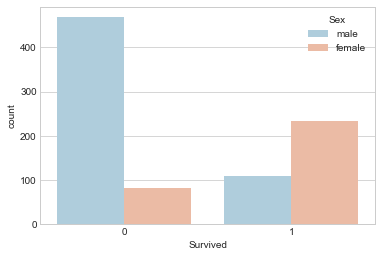

In [8]:
# the amount people is not survived more than bing survived
sns.countplot(x="Survived",data=train,hue="Sex",palette="RdBu_r")

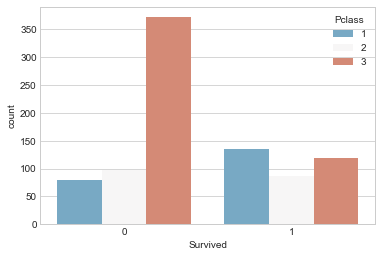

In [9]:
# 呈現 在 PClass 為 3 的較多人 is not survived
sns.countplot(x="Survived",data=train,hue="Pclass",palette="RdBu_r")

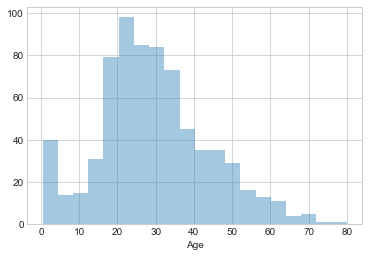

In [10]:
#因為Age有空值，所以
sns.distplot(train["Age"].dropna(),kde=False)

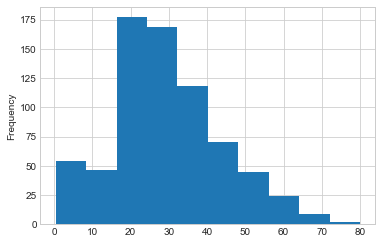

In [11]:
#若是直接將df 或是series呼叫.plot 可以直接省略空值 
train["Age"].plot.hist()

In [12]:
#文字呈現哪些特徵有空值
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


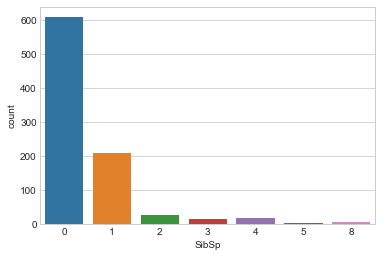

In [13]:
sns.countplot(x="SibSp",data=train)

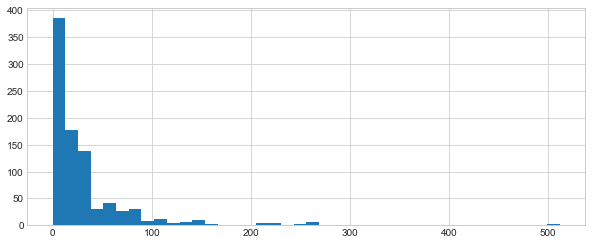

In [14]:
train["Fare"].hist(bins=40,figsize=(10,4))

In [15]:
cf.go_offline(connected=True)
#train["Fare"].iplot(kind="hist",bins=30)

In [16]:
#sns.heatmap(train.isnull(),cbar=False,yticklabels=False,cmap="viridis")

# Feature Preprocessing
- feature fillNa
- feature transformation
- feature busketerization
- 可以利用圖表直觀判定平均數

In [17]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


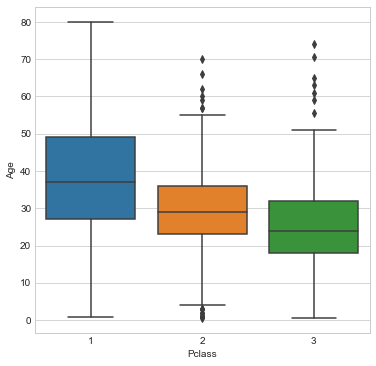

In [18]:
#可以看出 頭等艙 的人 年紀會較老
plt.figure(figsize=(6,6))
sns.boxplot(x="Pclass",y="Age",data=train)

In [19]:
#回傳平均數來代替空值
#之所以會什麼要選 各 Pclass 為類別的年齡平均，填值到 該類別內年齡的空值
#利用圖表直觀判定平均數
def impute_age(cols):
    Age = cols[0]
    Pclass =cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 28
        elif Pclass == 3:
            return 26
    else:
        return Age

In [20]:
train["Age"]=train[["Age","Pclass"]].apply(impute_age,axis=1)

In [21]:
# 成功填值
#sns.heatmap(train.isnull(),yticklabels=False,cmap="viridis")

In [22]:
train.drop("Cabin",axis=1,inplace=True)

In [23]:
train.dropna(inplace=True)

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [25]:
# 將類別資料轉成我們設定的dummy variables
train["Sex"]=train["Sex"].map({"male":1,"female":0})

In [26]:
# 產生虛擬變數 
sex=pd.get_dummies(train["Sex"],drop_first=True)

In [27]:
embarked=pd.get_dummies(train["Embarked"],drop_first=True)

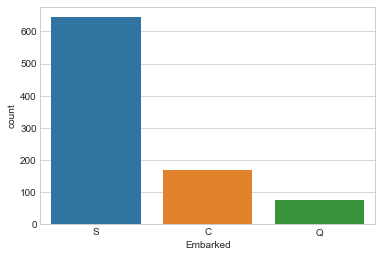

In [28]:
sns.countplot(x="Embarked",data=train)

In [29]:
train=pd.concat((train,sex,embarked),axis=1)

In [30]:
train.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,1,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,S,0,0,1


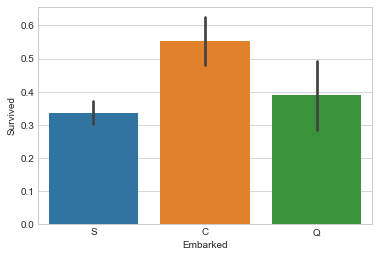

In [31]:
sns.barplot(x="Embarked",y="Survived",data=train)

In [32]:
train.drop(["Sex","Embarked","Name","Ticket"],axis=1,inplace=True)

In [33]:
train.head(3)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,1,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1


In [34]:
train.drop("PassengerId",axis=1,inplace=True)

In [35]:
train.head(3)

,Survived,Pclass,Age,SibSp,Parch,Fare,1,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1


# Create Machine Learning Algorithm

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

In [37]:
X=train.drop("Survived",axis=1)
y=train["Survived"]

In [38]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=95)

In [39]:
logR= LogisticRegression()
logR.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
prediction=logR.predict(X_test)
confusion_matrix(y_test,prediction)

array([[145,  11],
       [ 29,  82]])

In [41]:
from sklearn.metrics import classification_report

In [42]:
#著重 F1-score 作為評估一個 model 的指標
print(classification_report(y_test,prediction))

             precision    recall  f1-score   support

          0       0.83      0.93      0.88       156
          1       0.88      0.74      0.80       111

avg / total       0.85      0.85      0.85       267



In [43]:
result=confusion_matrix(y_test,prediction)
result

array([[145,  11],
       [ 29,  82]])

In [44]:
# 如果 sum(result) 會計算每欄的總和
score=(result[0][0]+result[1][1])/result.sum()
print("Logistic Regression Accuracy is :{}".format(score))

Logistic Regression Accuracy is :0.850187265917603


In [68]:
logR.coef_

array([[-0.71199253, -0.01647506, -0.27330318, -0.00857422,  0.00288432,
        -2.16260313, -0.14946785, -0.50071233]])

In [69]:
X_train.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 1, 'Q', 'S'], dtype='object')

In [60]:
print(X_train.columns)
print(logR.coef_)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 1, 'Q', 'S'], dtype='object')
[[-0.71199253 -0.01647506 -0.27330318 -0.00857422  0.00288432 -2.16260313
  -0.14946785 -0.50071233]]


In [70]:
# 顯現各個自變數的係數
coefficient=pd.DataFrame(data=logR.coef_[0], index=X_train.columns,columns=["coef"])

In [71]:
coefficient

,coef
Pclass,-0.711993
Age,-0.016475
SibSp,-0.273303
Parch,-0.008574
Fare,0.002884
1,-2.162603
Q,-0.149468
S,-0.500712
